In [31]:
from data_cleaning import Open, Stream, MakeMIDI, ChordEval
from music21 import chord, note, stream, clef, meter
import os
import numpy as np
import torch

In [32]:
mid_file1 = os.path.join(os.getcwd(), "progression1.mid")
midi_data1 = Open.open_midi(mid_file1)
mid_file2 = os.path.join(os.getcwd(), "progression2.mid")
midi_data2 = Open.open_midi(mid_file2)

In [24]:
mid_file_offset = os.path.join(os.getcwd(), "offset chord.mid")
midi_data_offset = Open.open_midi(mid_file_offset)

In [33]:
concatenated_array = []

In [35]:
for i, part in enumerate(midi_data2.parts):
    for element in part.recurse():
        if isinstance(element, chord.Chord):
            concatenated_array.append(element)

In [36]:
all_chords = []
for chord in concatenated_array:
    chord_arr = []
    for notes in chord:
        chord_arr.append(notes.pitch.ps)
    all_chords.append(chord_arr)

In [37]:
len(all_chords)

186

In [43]:
max(len(chord) for chord in all_chords)

6

In [44]:
min(len(chord) for chord in all_chords)

3

In [ ]:
sorted(b.items(), key=lambda kv: -kv[1])

In [38]:
N = torch.zeros((129, 129), dtype=torch.int32)

In [39]:
flattened_list = [int(element) for sublist in all_chords for element in sublist]

In [40]:
notes = sorted(set(flattened_list))

In [41]:
len(notes)

23

In [42]:
ntoi = {s: s for i, s in enumerate(notes)}
ntoi["."] = 128

In [ ]:
ntoi

In [44]:
for chord in all_chords:
    c_bigram = ["."] + chord + ["."]
    for c1, c2 in zip(c_bigram, c_bigram[1:]):
        ix1 = ntoi[c1]
        ix2 = ntoi[c2]
        N[ix1, ix2] += 1

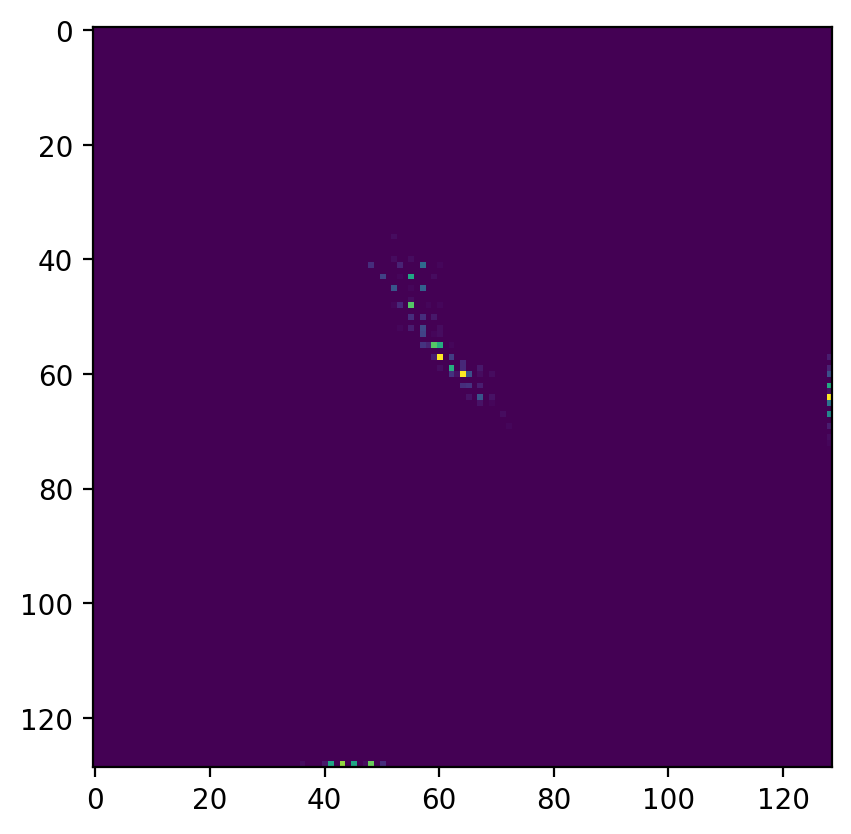

In [45]:
import matplotlib.pyplot as plt

plt.imshow(N)

# Sample the probabilities


In [49]:
P = N.float()
P=P/P.sum(1, keepdim=True)

In [50]:
g = torch.Generator().manual_seed(948376575)
midi_n = 0
numofc = 0
while True:

    p = P[midi_n]
    # p=torch.ones(128)/128
    if not torch.isnan(p).any().item():
        midi_n = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g).item()
        if not midi_n == 128:
            new_note = note.Note(midi_n)
            print(new_note.pitch)
    else:
        midi_n += 1
    if midi_n == 128:
        print("__")
        numofc += 1
        if numofc == 4:
            break

E3
C4
__
C3
F3
A3
C4
E4
__
A2
A3
C4
E4
__
F2
A3
C4
E4
__


# Finding all types of elements in a part


In [22]:
for part in midi_data_offset.parts:
    chords_array = []
    for idx, element in enumerate(part.recurse()):
        if isinstance(element, stream.Measure):
            print(idx, element)
        elif isinstance(element, clef.TrebleClef):
            print(idx, element)
        elif isinstance(element, meter.TimeSignature):
            print(idx, element)
        elif isinstance(element, chord.Chord):
            print(
                "CHord",
                [
                    [
                        n.pitch.ps,
                        n.volume.velocity,
                        n.duration.quarterLength,
                        n.duration.type,
                        n.offset,
                    ]
                    for n in element.notes
                ],
            )
        elif isinstance(element, note.Rest):
            print(idx, element)

0 <music21.stream.Measure 1 offset=0.0>
2 <music21.clef.TrebleClef>
3 <music21.meter.TimeSignature 4/4>
CHord [[60.0, 102, 1.0, 'quarter', 0.0], [65.0, 102, 1.0, 'quarter', 0.0]]
5 <music21.stream.Measure 2 offset=4.0>
6 <music21.note.Rest quarter>
CHord [[60.0, 100, 1.0, 'quarter', 0.0], [67.0, 102, 1.0, 'quarter', 0.0]]
8 <music21.note.Rest dotted-eighth>


In [184]:
for i, part in enumerate(midi_data_offset.parts):
    chords_array = []
    for idx, element in enumerate(part.recurse()):
        print(idx, element)
        if isinstance(element, chord.Chord):
            # if isinstance(part.recurse()[idx-1],)
            chord_array = [element]
            # for i, n in enumerate(element):
            #     chord_array.append(
            #         [int(n.pitch.ps), n.volume.velocity, n.duration.quarterLength, n.offset, 0])
            chords_array.append(chord_array)
    if chords_array:
        concatenated_array.append(chords_array)

0 <music21.stream.Measure 1 offset=0.0>
1 
2 <music21.clef.TrebleClef>
3 <music21.meter.TimeSignature 4/4>
4 <music21.chord.Chord C4 F4>
5 <music21.stream.Measure 2 offset=4.0>
6 <music21.note.Rest quarter>
7 <music21.chord.Chord C4 G4>
8 <music21.note.Rest dotted-eighth>
9 <music21.bar.Barline type=final>


In [185]:
concatenated_array

[[[<music21.chord.Chord C4 F4>], [<music21.chord.Chord C4 G4>]]]

# Outputting a MIDI file


In [158]:
s = stream.Score()

In [166]:
for each_file in concatenated_array:
    for chords in each_file:
        chord_arr = []
        for each_chord in chords:
            n = note.Note(each_chord[0])
            n.volume.velocity = each_chord[1]
            n.duration.quarterLength = each_chord[2]
            n.offset = each_chord[3]
            chord_arr.append(n)

        c = chord.Chord(chord_arr)
        s.append(c)

In [167]:
s

<music21.stream.Score 0x1ef6dc803d0>

In [168]:
s.write("midi", "output_file.mid")

'output_file.mid'